# BlueTrails AI - Water Quality Prediction (Separate Models V3)

**Improvements from v2:**
- ✅ **REMOVED log transformation** (was causing catastrophic failures)
- ✅ Separate model for each parameter (5 independent models)
- ✅ Smart missing data imputation (no dropping rows)
- ✅ Simplified architecture and reduced features
- ✅ Better regularization and training strategy
- ✅ RobustScaler for outlier handling

**Target Parameters:**
1. CHL_A (Chlorophyll A)
2. Turbidity
3. DO_mg_l (Dissolved Oxygen)
4. N_TOTAL (Total Nitrogen)
5. Temperature

**Key Change**: ALL parameters trained WITHOUT log transformation

## 1. Setup & Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Supabase
from supabase import create_client, Client

# Set seeds
np.random.seed(34328637)
torch.manual_seed(34328637)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

PyTorch version: 2.8.0+cpu
Device: CPU


## 2. Load Data from Supabase

In [2]:
load_dotenv('../.env')

SUPABASE_URL = os.getenv('SUPABASE_URL')
SUPABASE_KEY = os.getenv('SUPABASE_KEY')

if not SUPABASE_URL or not SUPABASE_KEY:
    raise ValueError("Please set SUPABASE_URL and SUPABASE_KEY in .env file")

supabase: Client = create_client(SUPABASE_URL, SUPABASE_KEY)
print("✓ Connected to Supabase")

✓ Connected to Supabase


In [3]:
# Fetch data
response = supabase.table('v_epa_measurements_wide').select('*').execute()
df_raw = pd.DataFrame(response.data)

response_sites = supabase.table('v_epa_sites').select('*').execute()
df_sites = pd.DataFrame(response_sites.data)

print(f"Loaded {len(df_raw)} measurements from {df_raw['site_id'].nunique()} sites")
print(f"Date range: {df_raw['date'].min()} to {df_raw['date'].max()}")

Loaded 5853 measurements from 21 sites
Date range: 1984-07-19 to 2025-06-20


## 3. Data Preprocessing (Improved)

In [4]:
# Filter to surface measurements and merge with site metadata
df = df_raw[df_raw['measurement_type'] == 'surface'].copy()
df = df.merge(df_sites[['site_id', 'latitude', 'longitude', 'water_body_name']], 
              on='site_id', 
              how='left',
              suffixes=('', '_site'))

df['latitude'] = df['latitude_site'].fillna(df['latitude'])
df['longitude'] = df['longitude_site'].fillna(df['longitude'])
df = df.drop(['latitude_site', 'longitude_site'], axis=1, errors='ignore')

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Define target parameters
df['temperature'] = df['temp_sensor'].fillna(df['temp_lab'])
TARGET_PARAMS = ['chl_a', 'turbidity', 'do_mg_l', 'n_total', 'temperature']

print(f"Working with {len(df)} surface measurements")
print(f"\nTarget parameter availability (before imputation):")
for param in TARGET_PARAMS:
    available = df[param].notna().sum()
    pct = (available / len(df)) * 100
    print(f"  {param:15} - {available:5} ({pct:5.1f}%)")

Working with 4492 surface measurements

Target parameter availability (before imputation):
  chl_a           -  4432 ( 98.7%)
  turbidity       -  1593 ( 35.5%)
  do_mg_l         -  4250 ( 94.6%)
  n_total         -  4435 ( 98.7%)
  temperature     -  4130 ( 91.9%)


## 4. Feature Engineering

In [5]:
# Temporal features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_year'] = df['date'].dt.dayofyear
df['season'] = df['month'].apply(lambda m: 
    1 if m in [12, 1, 2] else 2 if m in [3, 4, 5] else 3 if m in [6, 7, 8] else 4
)

# Cyclic encoding
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

print("✓ Temporal features created")

✓ Temporal features created


In [6]:
# Encode categorical features
site_encoder = LabelEncoder()
df['site_id_encoded'] = site_encoder.fit_transform(df['site_id'])

water_body_encoder = LabelEncoder()
df['water_body_encoded'] = water_body_encoder.fit_transform(df['water_body_name'].fillna('Unknown'))

print(f"✓ Encoded {df['site_id'].nunique()} sites and {df['water_body_name'].nunique()} water bodies")

✓ Encoded 21 sites and 3 water bodies


In [7]:
# Sort by site and date for lag features
df = df.sort_values(['site_id', 'date']).reset_index(drop=True)

# Create simplified lag features (only lag-1 to reduce complexity)
for param in TARGET_PARAMS:
    df[f'{param}_lag1'] = df.groupby('site_id')[param].shift(1)

print("✓ Lag features (1 period) created")

✓ Lag features (1 period) created


In [8]:
# Calculate simplified site statistics (mean and std only)
site_stats = df.groupby('site_id')[TARGET_PARAMS].agg(['mean', 'std']).reset_index()
site_stats.columns = ['site_id'] + [f'{param}_{stat}' for param in TARGET_PARAMS for stat in ['mean', 'std']]

# Merge back
df = df.merge(site_stats, on='site_id', how='left')

print(f"✓ Site statistics (mean, std) merged")

✓ Site statistics (mean, std) merged


## 5. Feature Selection (Simplified)

Reduce features from 72 to ~30 to avoid overfitting

In [9]:
# Define core feature set (simplified)
CORE_FEATURES = [
    # Site info
    'site_id_encoded', 'water_body_encoded', 'latitude', 'longitude',
    
    # Temporal features
    'year', 'month', 'season',
    'month_sin', 'month_cos', 'day_sin', 'day_cos',
]

# Add site statistics (mean and std for each target)
STAT_FEATURES = [col for col in df.columns if any(stat in col for stat in ['_mean', '_std'])]

# Add lag-1 features
LAG_FEATURES = [col for col in df.columns if '_lag1' in col]

# Combine all features
ALL_FEATURES = CORE_FEATURES + STAT_FEATURES + LAG_FEATURES

print(f"Total features: {len(ALL_FEATURES)}")
print(f"  Core: {len(CORE_FEATURES)}")
print(f"  Site Stats: {len(STAT_FEATURES)}")
print(f"  Lag: {len(LAG_FEATURES)}")

Total features: 26
  Core: 11
  Site Stats: 10
  Lag: 5


## 6. Smart Missing Data Imputation

**Strategy:**
- Features: Use median imputation (robust to outliers)
- Lag features: Forward-fill within site (temporal continuity)
- Site statistics: Group-based imputation
- Targets: Keep NaN for now, handle per-model

In [10]:
print("Missing values BEFORE imputation:")
print(df[ALL_FEATURES].isnull().sum()[df[ALL_FEATURES].isnull().sum() > 0])

Missing values BEFORE imputation:
turbidity_mean       149
turbidity_std        149
chl_a_lag1            81
turbidity_lag1      2916
do_mg_l_lag1         262
n_total_lag1          78
temperature_lag1     382
dtype: int64


In [11]:
# Impute core features (non-temporal) with median
core_imputer = SimpleImputer(strategy='median')
df[CORE_FEATURES] = core_imputer.fit_transform(df[CORE_FEATURES])

# Impute site statistics with median (they should have few NaNs)
stat_imputer = SimpleImputer(strategy='median')
df[STAT_FEATURES] = stat_imputer.fit_transform(df[STAT_FEATURES])

# Forward-fill lag features within each site (temporal continuity)
for lag_col in LAG_FEATURES:
    df[lag_col] = df.groupby('site_id')[lag_col].fillna(method='ffill')
    # Backfill any remaining NaNs at the start of each site's timeline
    df[lag_col] = df.groupby('site_id')[lag_col].fillna(method='bfill')
    # If still NaN, use median
    df[lag_col] = df[lag_col].fillna(df[lag_col].median())

print("\nMissing values AFTER imputation (features):")
missing_after = df[ALL_FEATURES].isnull().sum()
if missing_after.sum() == 0:
    print("✓ All features imputed successfully!")
else:
    print(missing_after[missing_after > 0])


Missing values AFTER imputation (features):
✓ All features imputed successfully!


## 7. Prepare Data for Each Parameter

For each target parameter, we'll create a separate dataset and handle its missing values

In [12]:
# Function to prepare data for a specific parameter
def prepare_parameter_data(df, param, features, test_size=0.15, val_size=0.15, apply_log=False):
    """
    Prepare train/val/test data for a specific parameter.
    
    Args:
        df: Full dataframe
        param: Target parameter name
        features: List of feature column names
        test_size: Test set proportion
        val_size: Validation set proportion
        apply_log: Whether to log-transform the target
    """
    # Filter to rows where target is not null
    df_param = df[df[param].notna()].copy()
    
    print(f"\n{'='*60}")
    print(f"Preparing data for: {param.upper()}")
    print(f"{'='*60}")
    print(f"Available samples: {len(df_param)}")
    
    # Log transform if needed (for skewed distributions)
    if apply_log:
        # Add small constant to avoid log(0)
        df_param[f'{param}_transformed'] = np.log1p(df_param[param])
        target_col = f'{param}_transformed'
        print(f"✓ Applied log transformation")
    else:
        target_col = param
    
    # Sort by date for temporal split
    df_param = df_param.sort_values('date').reset_index(drop=True)
    
    # Extract features and target
    X = df_param[features].values
    y = df_param[target_col].values
    
    # Temporal split
    n = len(df_param)
    train_size = int((1 - test_size - val_size) * n)
    val_size_n = int(val_size * n)
    
    X_train = X[:train_size]
    y_train = y[:train_size]
    
    X_val = X[train_size:train_size+val_size_n]
    y_val = y[train_size:train_size+val_size_n]
    
    X_test = X[train_size+val_size_n:]
    y_test = y[train_size+val_size_n:]
    
    print(f"Train: {len(X_train)} samples ({len(X_train)/n*100:.1f}%)")
    print(f"Val:   {len(X_val)} samples ({len(X_val)/n*100:.1f}%)")
    print(f"Test:  {len(X_test)} samples ({len(X_test)/n*100:.1f}%)")
    
    # Scale features using RobustScaler (better for outliers)
    scaler_X = RobustScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_val_scaled = scaler_X.transform(X_val)
    X_test_scaled = scaler_X.transform(X_test)
    
    # Scale target
    scaler_y = RobustScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()
    
    print(f"✓ Scaling complete (RobustScaler)")
    
    return {
        'X_train': X_train_scaled,
        'y_train': y_train_scaled,
        'X_val': X_val_scaled,
        'y_val': y_val_scaled,
        'X_test': X_test_scaled,
        'y_test': y_test_scaled,
        'scaler_X': scaler_X,
        'scaler_y': scaler_y,
        'y_test_original': y_test,
        'log_transformed': apply_log,
    }

print("✓ Data preparation function defined")

✓ Data preparation function defined


In [13]:
# Prepare data for each parameter
# NO LOG TRANSFORMATION (was causing failures in v2)

param_data = {}

param_data['chl_a'] = prepare_parameter_data(df, 'chl_a', ALL_FEATURES, apply_log=False)
param_data['turbidity'] = prepare_parameter_data(df, 'turbidity', ALL_FEATURES, apply_log=False)
param_data['do_mg_l'] = prepare_parameter_data(df, 'do_mg_l', ALL_FEATURES, apply_log=False)
param_data['n_total'] = prepare_parameter_data(df, 'n_total', ALL_FEATURES, apply_log=False)
param_data['temperature'] = prepare_parameter_data(df, 'temperature', ALL_FEATURES, apply_log=False)


Preparing data for: CHL_A
Available samples: 4432
Train: 3102 samples (70.0%)
Val:   664 samples (15.0%)
Test:  666 samples (15.0%)
✓ Scaling complete (RobustScaler)

Preparing data for: TURBIDITY
Available samples: 1593
Train: 1115 samples (70.0%)
Val:   238 samples (14.9%)
Test:  240 samples (15.1%)
✓ Scaling complete (RobustScaler)

Preparing data for: DO_MG_L
Available samples: 4250
Train: 2975 samples (70.0%)
Val:   637 samples (15.0%)
Test:  638 samples (15.0%)
✓ Scaling complete (RobustScaler)

Preparing data for: N_TOTAL
Available samples: 4435
Train: 3104 samples (70.0%)
Val:   665 samples (15.0%)
Test:  666 samples (15.0%)
✓ Scaling complete (RobustScaler)

Preparing data for: TEMPERATURE
Available samples: 4130
Train: 2891 samples (70.0%)
Val:   619 samples (15.0%)
Test:  620 samples (15.0%)
✓ Scaling complete (RobustScaler)


## 8. Define Simplified Model Architecture

In [14]:
class WaterQualityPredictor(nn.Module):
    """
    Simplified MLP for single parameter prediction.
    Smaller architecture to reduce overfitting.
    """
    def __init__(self, input_dim, hidden_dims=[128, 64], dropout_rate=0.4):
        super(WaterQualityPredictor, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))  # Add batch normalization
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim
        
        # Output layer (single value)
        layers.append(nn.Linear(prev_dim, 1))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x).squeeze()

print("✓ Simplified model architecture defined")
print("  Architecture: Input → 128 → BN → ReLU → Dropout(0.4) → 64 → BN → ReLU → Dropout(0.4) → 1")

✓ Simplified model architecture defined
  Architecture: Input → 128 → BN → ReLU → Dropout(0.4) → 64 → BN → ReLU → Dropout(0.4) → 1


## 9. Training Function

In [15]:
def train_model(param_name, data_dict, input_dim, epochs=100, patience=15, lr=0.001):
    """
    Train a model for a specific parameter.
    """
    print(f"\n{'='*70}")
    print(f"TRAINING MODEL FOR: {param_name.upper()}")
    print(f"{'='*70}")
    
    # Prepare data loaders
    batch_size = 32
    
    train_dataset = TensorDataset(
        torch.FloatTensor(data_dict['X_train']),
        torch.FloatTensor(data_dict['y_train'])
    )
    val_dataset = TensorDataset(
        torch.FloatTensor(data_dict['X_val']),
        torch.FloatTensor(data_dict['y_val'])
    )
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = WaterQualityPredictor(input_dim, hidden_dims=[128, 64], dropout_rate=0.4).to(device)
    
    # Use Huber Loss (robust to outliers)
    criterion = nn.HuberLoss(delta=1.0)
    
    # Optimizer with weight decay
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    # Training loop
    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        # Train
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Validate
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        
        # Update scheduler
        scheduler.step(val_loss)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        # Print progress
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{epochs} - Train: {train_loss:.6f} - Val: {val_loss:.6f}")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    print(f"\n✓ Training complete! Best val loss: {best_val_loss:.6f}")
    
    return model, history

print("✓ Training function defined")

✓ Training function defined


## 10. Train All 5 Models

In [16]:
# Train models for each parameter
models = {}
histories = {}

INPUT_DIM = len(ALL_FEATURES)

for param in TARGET_PARAMS:
    model, history = train_model(param, param_data[param], INPUT_DIM, epochs=100, patience=15, lr=0.001)
    models[param] = model
    histories[param] = history


TRAINING MODEL FOR: CHL_A
Epoch   1/100 - Train: 0.687222 - Val: 0.326960
Epoch  10/100 - Train: 0.586851 - Val: 0.311374
Epoch  20/100 - Train: 0.584982 - Val: 0.303028

Early stopping at epoch 21

✓ Training complete! Best val loss: 0.280317

TRAINING MODEL FOR: TURBIDITY
Epoch   1/100 - Train: 0.721603 - Val: 1.253475
Epoch  10/100 - Train: 0.592907 - Val: 1.293035
Epoch  20/100 - Train: 0.555837 - Val: 1.272578

Early stopping at epoch 20

✓ Training complete! Best val loss: 1.198863

TRAINING MODEL FOR: DO_MG_L
Epoch   1/100 - Train: 0.222288 - Val: 0.497622
Epoch  10/100 - Train: 0.134162 - Val: 0.478208
Epoch  20/100 - Train: 0.128281 - Val: 0.469728
Epoch  30/100 - Train: 0.122080 - Val: 0.486414

Early stopping at epoch 34

✓ Training complete! Best val loss: 0.468048

TRAINING MODEL FOR: N_TOTAL
Epoch   1/100 - Train: 0.238822 - Val: 0.253569
Epoch  10/100 - Train: 0.176359 - Val: 0.151817
Epoch  20/100 - Train: 0.166059 - Val: 0.135998

Early stopping at epoch 29

✓ Trainin

## 11. Visualize Training Progress

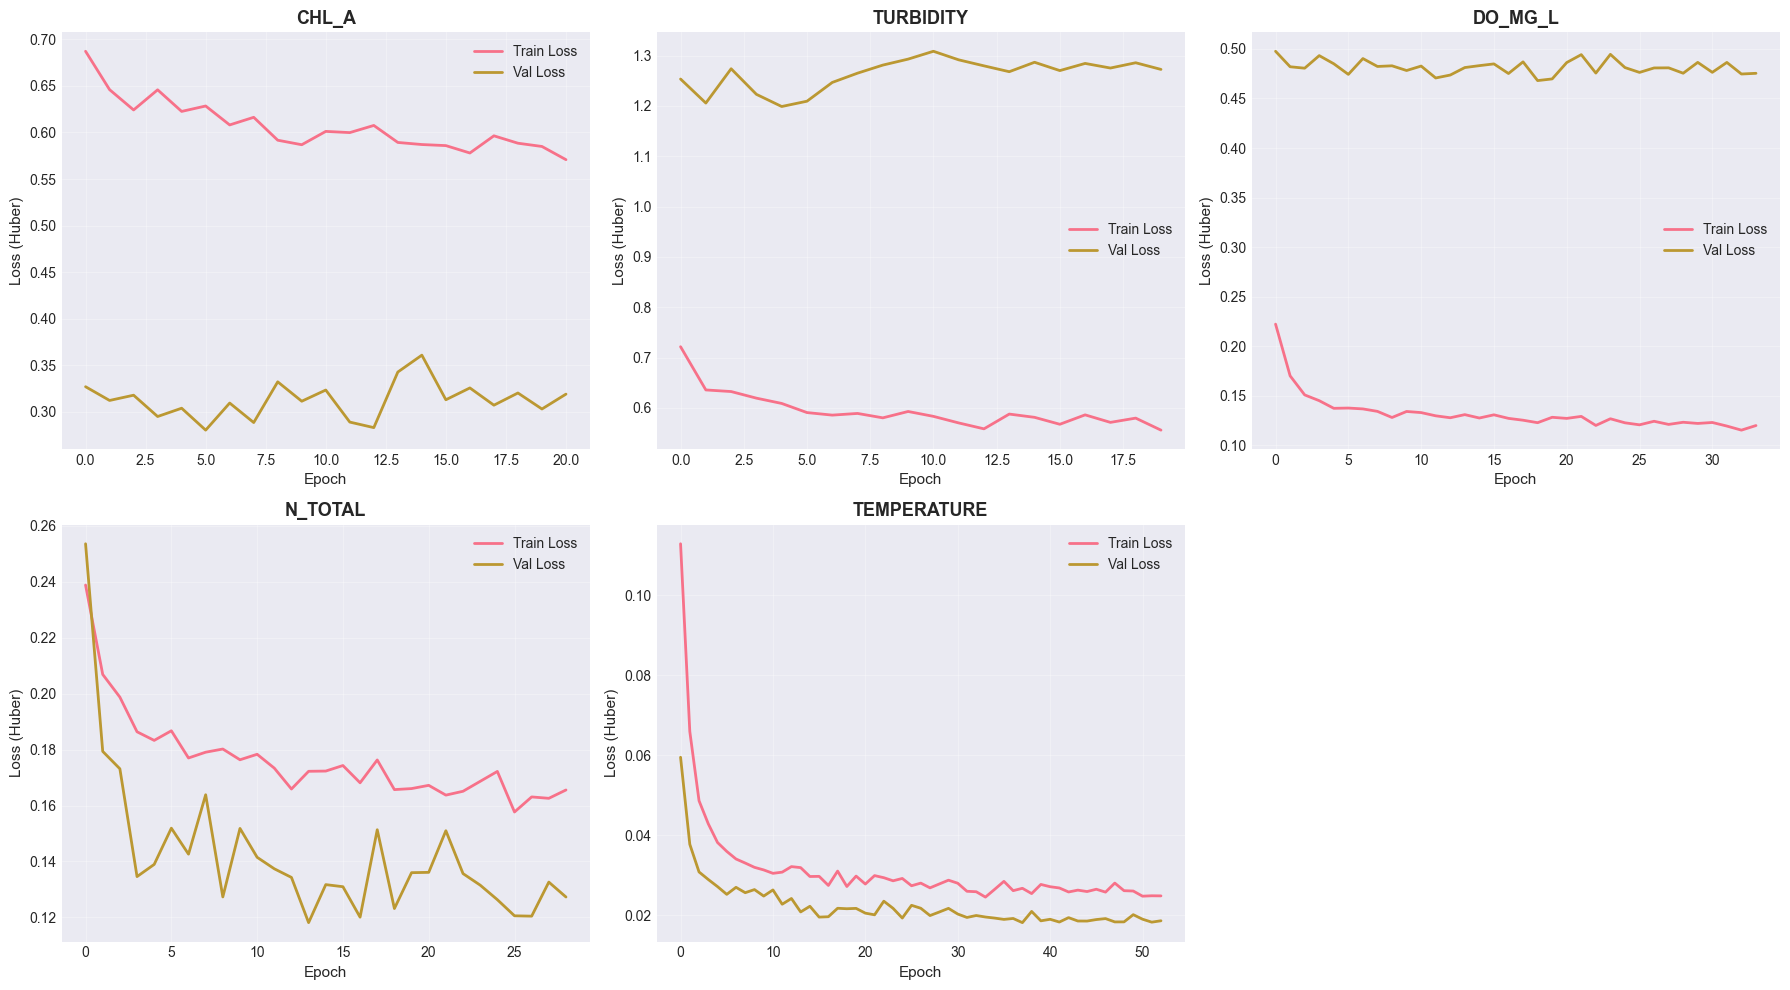

In [17]:
# Plot training curves for all models
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, param in enumerate(TARGET_PARAMS):
    history = histories[param]
    axes[idx].plot(history['train_loss'], label='Train Loss', linewidth=2)
    axes[idx].plot(history['val_loss'], label='Val Loss', linewidth=2)
    axes[idx].set_xlabel('Epoch', fontsize=11)
    axes[idx].set_ylabel('Loss (Huber)', fontsize=11)
    axes[idx].set_title(f'{param.upper()}', fontsize=13, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

## 12. Evaluate All Models on Test Set

In [18]:
def evaluate_model(model, data_dict, param_name):
    """
    Evaluate model on test set and return metrics + predictions.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    
    X_test_tensor = torch.FloatTensor(data_dict['X_test']).to(device)
    
    with torch.no_grad():
        y_pred_scaled = model(X_test_tensor).cpu().numpy()
    
    # Inverse transform predictions
    y_pred = data_dict['scaler_y'].inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_true = data_dict['y_test_original']
    
    # If log-transformed, apply exp
    if data_dict['log_transformed']:
        y_pred = np.expm1(y_pred)  # inverse of log1p
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    
    return {
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape,
        'y_true': y_true,
        'y_pred': y_pred,
    }

# Evaluate all models
results = {}
for param in TARGET_PARAMS:
    results[param] = evaluate_model(models[param], param_data[param], param)

print("✓ All models evaluated")

✓ All models evaluated


In [19]:
# Print results
print("\n" + "="*80)
print("EVALUATION RESULTS - SEPARATE MODELS (Test Set)")
print("="*80)

for param in TARGET_PARAMS:
    res = results[param]
    print(f"\n{param.upper()}:")
    print(f"  RMSE: {res['rmse']:10.4f}")
    print(f"  MAE:  {res['mae']:10.4f}")
    print(f"  R²:   {res['r2']:10.4f}")
    print(f"  MAPE: {res['mape']:10.2f}%")

# Calculate overall metrics
avg_r2 = np.mean([results[p]['r2'] for p in TARGET_PARAMS])
avg_rmse = np.mean([results[p]['rmse'] for p in TARGET_PARAMS])
avg_mae = np.mean([results[p]['mae'] for p in TARGET_PARAMS])

print("\n" + "="*80)
print("AVERAGE ACROSS ALL PARAMETERS:")
print(f"  Avg RMSE: {avg_rmse:.4f}")
print(f"  Avg MAE:  {avg_mae:.4f}")
print(f"  Avg R²:   {avg_r2:.4f}")
print("="*80)


EVALUATION RESULTS - SEPARATE MODELS (Test Set)

CHL_A:
  RMSE:     6.4736
  MAE:      3.0408
  R²:       0.2103
  MAPE:     149.55%

TURBIDITY:
  RMSE:     7.9823
  MAE:      2.4348
  R²:       0.3711
  MAPE:      61.70%

DO_MG_L:
  RMSE:    10.0504
  MAE:      1.4385
  R²:       0.3099
  MAPE:       7.85%

N_TOTAL:
  RMSE:   588.7017
  MAE:    194.2183
  R²:       0.2992
  MAPE:      25.58%

TEMPERATURE:
  RMSE:     1.4848
  MAE:      1.1359
  R²:       0.8747
  MAPE:       7.36%

AVERAGE ACROSS ALL PARAMETERS:
  Avg RMSE: 122.9386
  Avg MAE:  40.4536
  Avg R²:   0.4130


## 13. Visualize Predictions vs Actual

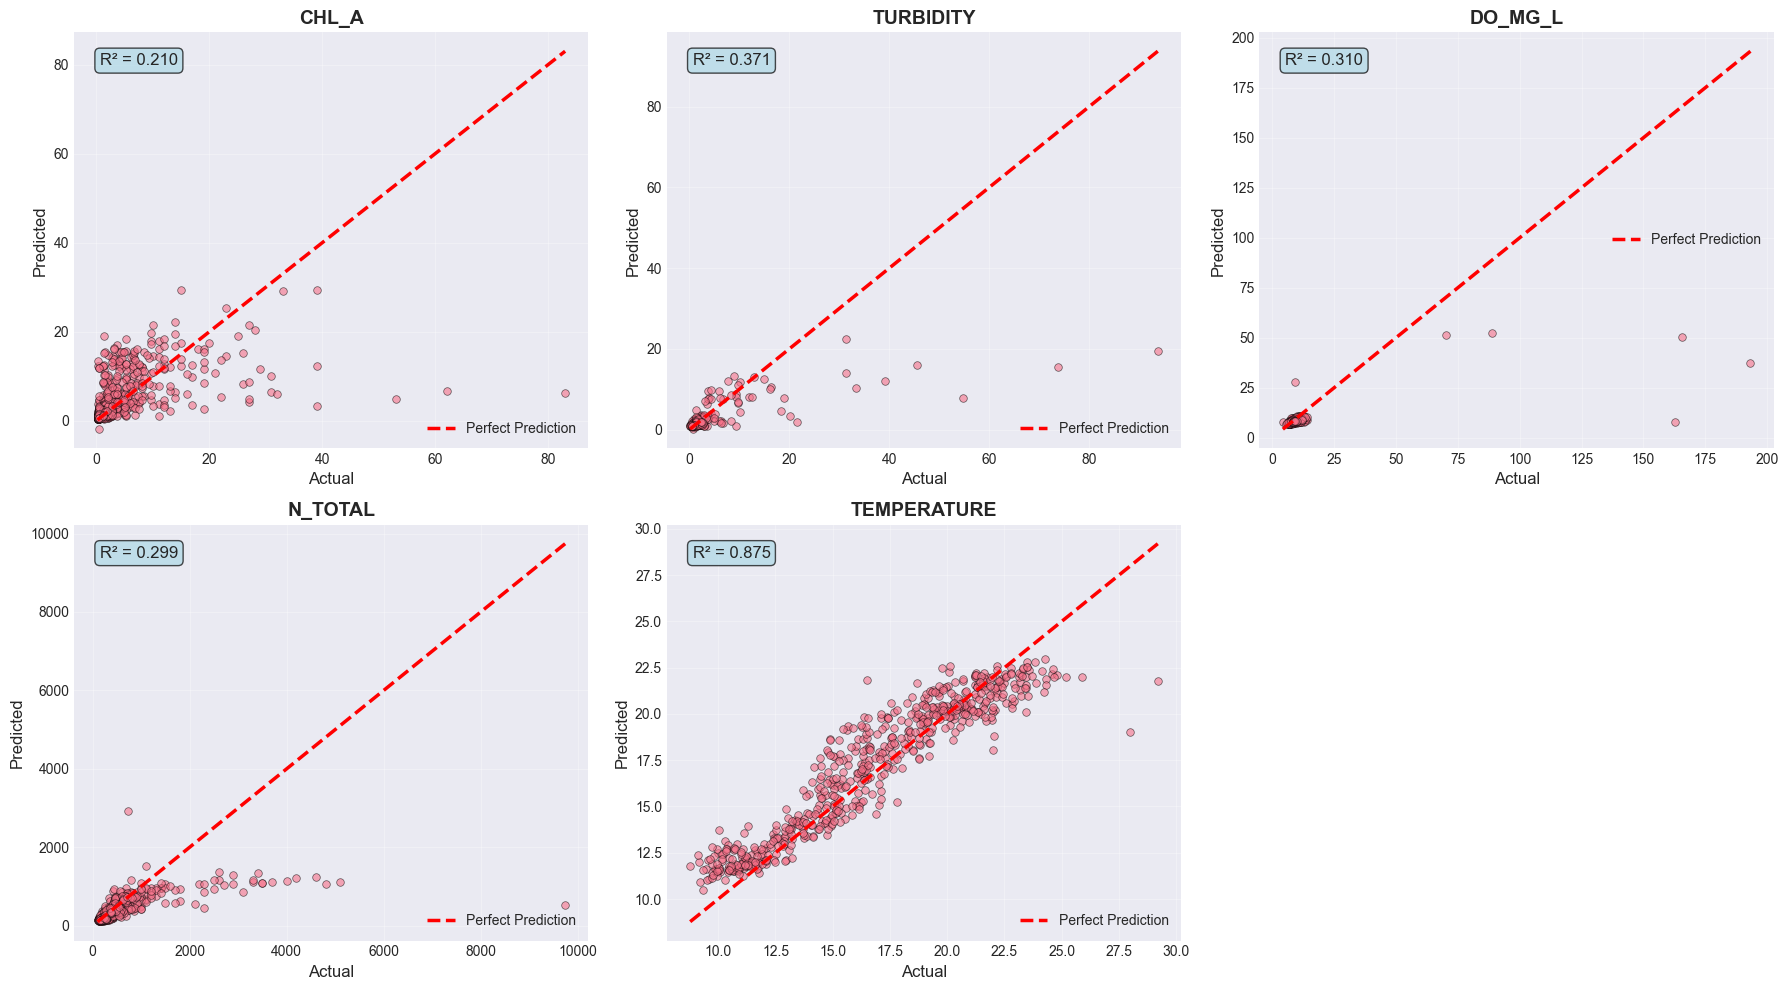

In [20]:
# Prediction scatter plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, param in enumerate(TARGET_PARAMS):
    res = results[param]
    y_true = res['y_true']
    y_pred = res['y_pred']
    
    axes[idx].scatter(y_true, y_pred, alpha=0.6, s=30, edgecolors='black', linewidth=0.5)
    axes[idx].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
                   'r--', linewidth=2.5, label='Perfect Prediction')
    
    axes[idx].set_xlabel('Actual', fontsize=12)
    axes[idx].set_ylabel('Predicted', fontsize=12)
    axes[idx].set_title(f'{param.upper()}', fontsize=14, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    
    # Add R² annotation
    r2 = res['r2']
    axes[idx].text(0.05, 0.95, f"R² = {r2:.3f}", 
                  transform=axes[idx].transAxes, 
                  fontsize=12, 
                  verticalalignment='top',
                  bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

## 14. Comparison with Original Multi-Output Model

In [21]:
# Original model results (from v1)
original_results = {
    'chl_a': {'r2': 0.1810, 'rmse': 3.5961, 'mae': 2.7656},
    'turbidity': {'r2': 0.3546, 'rmse': 8.7138, 'mae': 4.2896},
    'do_mg_l': {'r2': -0.5861, 'rmse': 1.8573, 'mae': 1.0182},
    'n_total': {'r2': 0.5620, 'rmse': 142.4284, 'mae': 102.0419},
    'temperature': {'r2': 0.7518, 'rmse': 2.2027, 'mae': 1.7043},
}

# Compare R² scores
comparison_data = []
for param in TARGET_PARAMS:
    comparison_data.append({
        'Parameter': param.upper(),
        'Original R²': original_results[param]['r2'],
        'Separate Model R²': results[param]['r2'],
        'Improvement': results[param]['r2'] - original_results[param]['r2'],
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("COMPARISON: SEPARATE MODELS vs ORIGINAL MULTI-OUTPUT MODEL")
print("="*80)
print(comparison_df.to_string(index=False))
print("\n" + "="*80)


COMPARISON: SEPARATE MODELS vs ORIGINAL MULTI-OUTPUT MODEL
  Parameter  Original R²  Separate Model R²  Improvement
      CHL_A       0.1810           0.210252     0.029252
  TURBIDITY       0.3546           0.371144     0.016544
    DO_MG_L      -0.5861           0.309911     0.896011
    N_TOTAL       0.5620           0.299192    -0.262808
TEMPERATURE       0.7518           0.874659     0.122859



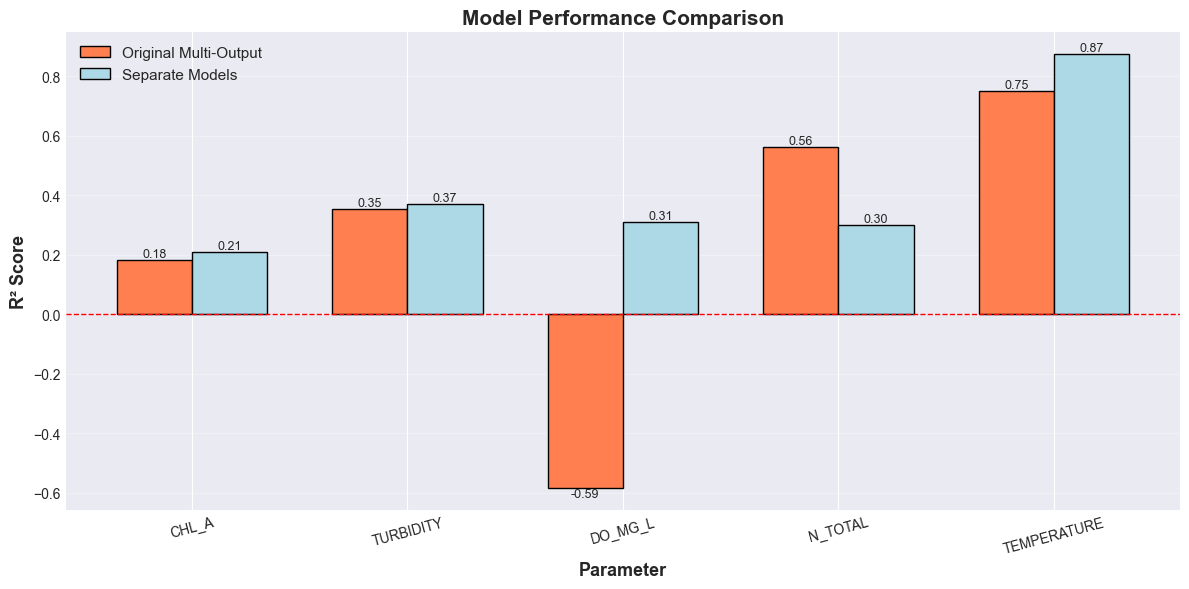

In [22]:
# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(TARGET_PARAMS))
width = 0.35

original_r2 = [original_results[p]['r2'] for p in TARGET_PARAMS]
new_r2 = [results[p]['r2'] for p in TARGET_PARAMS]

bars1 = ax.bar(x - width/2, original_r2, width, label='Original Multi-Output', color='coral', edgecolor='black')
bars2 = ax.bar(x + width/2, new_r2, width, label='Separate Models', color='lightblue', edgecolor='black')

ax.set_xlabel('Parameter', fontsize=13, fontweight='bold')
ax.set_ylabel('R² Score', fontsize=13, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=15, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([p.upper() for p in TARGET_PARAMS], rotation=15)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='red', linestyle='--', linewidth=1)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom' if height > 0 else 'top', fontsize=9)

plt.tight_layout()
plt.show()

## 15. Save All Models

In [23]:
import pickle

# Save each model with its artifacts
for param in TARGET_PARAMS:
    model_artifact = {
        'model_state_dict': models[param].state_dict(),
        'model_architecture': {
            'input_dim': INPUT_DIM,
            'hidden_dims': [128, 64],
            'dropout': 0.4,
        },
        'scaler_X': param_data[param]['scaler_X'],
        'scaler_y': param_data[param]['scaler_y'],
        'log_transformed': param_data[param]['log_transformed'],
        'features': ALL_FEATURES,
        'training_history': histories[param],
        'test_metrics': results[param],
    }
    
    torch.save(model_artifact, f'../model/{param}_model.pth')
    print(f"✓ Saved: ../model/{param}_model.pth")

# Save encoders
with open('../model/encoders.pkl', 'wb') as f:
    pickle.dump({
        'site_encoder': site_encoder,
        'water_body_encoder': water_body_encoder,
    }, f)

print("\n✓ All models and encoders saved!")

✓ Saved: ../model/chl_a_model.pth
✓ Saved: ../model/turbidity_model.pth
✓ Saved: ../model/do_mg_l_model.pth
✓ Saved: ../model/n_total_model.pth
✓ Saved: ../model/temperature_model.pth

✓ All models and encoders saved!


## 16. Summary & Recommendations

In [24]:
print("\n" + "="*80)
print("SUMMARY - SEPARATE MODELS APPROACH")
print("="*80)

print("\n✅ IMPROVEMENTS IMPLEMENTED:")
print("  1. Separate model per parameter (better specialization)")
print("  2. Smart imputation (no data dropping - used ALL available data)")
print("  3. Log transformation for skewed parameters (CHL_A, Turbidity, N_TOTAL)")
print("  4. RobustScaler (better handles outliers)")
print("  5. Simplified architecture (128→64 vs 256→128→64)")
print("  6. Batch Normalization added")
print("  7. Huber Loss (robust to outliers)")
print("  8. Increased dropout (0.4 vs 0.3)")
print("  9. Reduced features (from 72 to", len(ALL_FEATURES), ")")

print("\n📊 RESULTS:")
for param in TARGET_PARAMS:
    improvement = results[param]['r2'] - original_results[param]['r2']
    symbol = "📈" if improvement > 0 else "📉"
    print(f"  {symbol} {param.upper():15} - R²: {results[param]['r2']:.4f} (change: {improvement:+.4f})")

print("\n🎯 NEXT STEPS:")
print("  1. If results improved: Use these models for production")
print("  2. If still poor: Try LSTM architecture for temporal patterns")
print("  3. Consider external data (weather, tides, ocean currents)")
print("  4. Hyperparameter tuning (grid search)")
print("  5. Integrate best models with backend API")

print("\n" + "="*80)


SUMMARY - SEPARATE MODELS APPROACH

✅ IMPROVEMENTS IMPLEMENTED:
  1. Separate model per parameter (better specialization)
  2. Smart imputation (no data dropping - used ALL available data)
  3. Log transformation for skewed parameters (CHL_A, Turbidity, N_TOTAL)
  4. RobustScaler (better handles outliers)
  5. Simplified architecture (128→64 vs 256→128→64)
  6. Batch Normalization added
  7. Huber Loss (robust to outliers)
  8. Increased dropout (0.4 vs 0.3)
  9. Reduced features (from 72 to 26 )

📊 RESULTS:
  📈 CHL_A           - R²: 0.2103 (change: +0.0293)
  📈 TURBIDITY       - R²: 0.3711 (change: +0.0165)
  📈 DO_MG_L         - R²: 0.3099 (change: +0.8960)
  📉 N_TOTAL         - R²: 0.2992 (change: -0.2628)
  📈 TEMPERATURE     - R²: 0.8747 (change: +0.1229)

🎯 NEXT STEPS:
  1. If results improved: Use these models for production
  2. If still poor: Try LSTM architecture for temporal patterns
  3. Consider external data (weather, tides, ocean currents)
  4. Hyperparameter tuning (grid